# Q1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import graphviz

class TreeNode:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.gain_ratio = None
        self.left = None
        self.right = None
        self.value = None
        self.id = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Check if we've reached the maximum depth or if all samples have the same class
        if self.depth == self.max_depth or len(unique_classes) == 1:
            self.value = unique_classes[0]
            return

        best_gain_ratio = -1  # Initialize with a value less than any valid gain ratio
        best_feature_index = None
        best_threshold = None
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            #print(thresholds)
            for threshold in thresholds:
                y_left = y[X[:, feature_index] >= threshold]  # Change the condition to xj >= c
                y_right = y[X[:, feature_index] < threshold]  # Change the condition to xj < c
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Calculate information gain
                entropy_before = self.calculate_entropy(y)
                entropy_left = self.calculate_entropy(y_left)
                entropy_right = self.calculate_entropy(y_right)
                info_gain = entropy_before - (len(y_left) / n_samples) * entropy_left - (len(y_right) / n_samples) * entropy_right
                #print(info_gain)
                # Calculate split information for gain ratio
                split_info = -(len(y_left) / n_samples) * np.log2(len(y_left) / n_samples + 1e-10) - \
                             (len(y_right) / n_samples) * np.log2(len(y_right) / n_samples + 1e-10)
                #print(split_info)
                # Skip candidate splits with zero split information
                if split_info == 0:
                    continue

                # Avoid division by zero and check for stopping criteria
                if info_gain == 0 and (entropy_left != 0 or entropy_right != 0):
                    continue

                # Calculate gain ratio
                gain_ratio = info_gain / split_info

                if gain_ratio > best_gain_ratio:
                    best_gain_ratio = gain_ratio
                    best_feature_index = feature_index
                    best_threshold = threshold




        #print(best_feature_index)
        #print(best_threshold)
        self.feature_index = best_feature_index
        self.threshold = best_threshold
        self.gain_ratio = best_gain_ratio
        if best_feature_index != None:
            X_left = X[X[:, best_feature_index] >= best_threshold]  # Change the condition to xj >= c
            y_left = y[X[:, best_feature_index] >= best_threshold]  # Change the condition to xj >= c
            X_right = X[X[:, best_feature_index] < best_threshold]  # Change the condition to xj < c
            y_right = y[X[:, best_feature_index] < best_threshold]  # Change the condition to xj < c
            self.left = TreeNode(self.depth + 1, self.max_depth)
            self.right = TreeNode(self.depth + 1, self.max_depth)
            self.left.fit(X_left, y_left)
            self.right.fit(X_right, y_right)
        else:
            n1 = np.sum(y == 1)
            if n1 >= n_samples / 2:
                self.value = 1
            else:
                self.value = 0

    #     self.set_node_ids(self.root)

    # def set_node_ids(self, node, id_prefix=""):
    #     if node is not None:
    #         node.id = id_prefix + str(node.depth)
    #         self.set_node_ids(node.left, node.id + "L")
    #         self.set_node_ids(node.right, node.id + "R")


    def predict(self, X):
        if self.feature_index is None:
            return np.array([self.value] * len(X))
        else:
            mask = X[:, self.feature_index] >= self.threshold  # Change the condition to xj >= c
            X_left = X[mask]
            X_right = X[~mask]
            y_pred = np.empty(len(X), dtype=int)
            y_pred[mask] = self.left.predict(X_left)
            y_pred[~mask] = self.right.predict(X_right)
            return y_pred

    @staticmethod
    def calculate_entropy(y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
        return entropy

    def print_tree(self, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"], indent=""):
        if self.feature_index is None:
            #pass
            print(indent + "Class:", class_names[int(self.value)])
        else:
            feature_name = feature_names[self.feature_index] if feature_names else f"Feature {self.feature_index}"
            print(indent + f"if {feature_name} >= {self.threshold:.4f}:")
            self.left.print_tree(feature_names, class_names, indent + "  ")
            print(indent + f"else:")
            self.right.print_tree(feature_names, class_names, indent + "  ")


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        # Check for the case where there's only one class
        if len(unique_classes) == 1:
            self.root = TreeNode(value=unique_classes[0])
        else:
            self.root = TreeNode(max_depth=self.max_depth)
            self.root.fit(X, y)

        self.set_node_ids(self.root)


    def predict(self, X):
        return self.root.predict(X)

    def print_tree(self, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"]):
        if self.root is not None:
            self.root.print_tree(feature_names, class_names)

    def set_node_ids(self, node, id_prefix=""):
        if node is not None:
            node.id = id_prefix + str(node.depth)
            self.set_node_ids(node.left, node.id + "L")
            self.set_node_ids(node.right, node.id + "R")


# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

# # ... (Rest of your code)

# class DecisionTreeClassifier:
    # ... (Rest of your code)




    def plot_decision_boundary(self, X, y, feature_names=['feature 1', 'feature 2'], class_names=['0,1']):
        if X.shape[1] != 2:
            raise ValueError("This method is only for visualizing 2-D data.")

        if self.root is None:
            raise ValueError("The decision tree has not been trained.")

        # Create a mesh grid for the feature space
        buffer = 0.05
        x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
        y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

        # Make predictions for all points in the mesh grid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Create a color map for the plot
        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])

        # Plot the decision boundary
        plt.figure(figsize=(8, 6))
        # Calculate custom limits for the x and y axes
        x_margin = (x_max - x_min) * 0.1  # 10% margin
        y_margin = (y_max - y_min) * 0.1  # 10% margin



        plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

        # Plot the data points
       # Plot the data points with distinct colors for each class
        cmap_data = ListedColormap(['#FF0000', '#0000FF'])
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_data, edgecolor='k', s=20)

        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title('Decision Boundary of the Trained Decision Tree')

        if feature_names:
            plt.xticks([])
            plt.yticks([])
            plt.xlabel(feature_names[0])
            plt.ylabel(feature_names[1])

        plt.show()


def visualize_decision_tree_graphviz(clf, file_name = 'decision_tree_graph', feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"]):
    dot = graphviz.Digraph(format='png')
    visualize_tree_recursive(dot, clf.root, feature_names, class_names)
    dot.render(file_name, view=True)  # Output will be saved as 'decision_tree_graph.png' and opened

def visualize_tree_recursive(dot, node, feature_names, class_names):
    if node is not None:
        if node.feature_index is not None:
            feature_name = feature_names[node.feature_index] if feature_names else f"Feature {node.feature_index}"
            threshold = f"{node.threshold:.2f}"
            label = f"{feature_name} >= {threshold}\nInformation Gain Ratio: {node.gain_ratio:.2f}"
        else:
            label = class_names[int(node.value)]

        dot.node(node.id, label=label)
        if node.left is not None:
            dot.edge(node.id, node.left.id, label="True")
            visualize_tree_recursive(dot, node.left, feature_names, class_names)
        if node.right is not None:
            dot.edge(node.id, node.right.id, label="False")
            visualize_tree_recursive(dot, node.right, feature_names, class_names)



# # Example usage:
# if __name__ == "__main__":
#     # ... (previous code) ...

#     # Create synthetic data for binary classification (2-D)
#     np.random.seed(0)
#     n = 200
#     X = np.random.rand(n, 2)
#     y = (X[:, 0] + X[:, 1] > 1).astype(int)  # Creating a decision boundary at x + y = 1

#     # Fit the decision tree classifier
#     classifier = DecisionTreeClassifier(max_depth=5)
#     classifier.fit(X, y)

#     # Plot the decision boundary
#     classifier.plot_decision_boundary(X, y)



# Example usage:
if __name__ == "__main__":
    # Create synthetic data for binary classification (0 or 1)
    #np.random.seed(0)
    n = 10
    X = np.random.rand(n, 2)
    y = np.random.randint(0, 2, size=n)

    # Fit the decision tree classifier
    classifier = DecisionTreeClassifier()
    classifier.fit(X, y)

    # Predict
    X_test = np.random.rand(10, 2)
    y_pred = classifier.predict(X_test)

    print("Predicted classes:", y_pred)

    def count_nodes(node):
        if node is None:
            return 0
        else:
            return 1 + count_nodes(node.left) + count_nodes(node.right)

    # Assuming you have already trained the decision tree classifier
    # classifier = DecisionTreeClassifier(max_depth=5)
    # classifier.fit(X, y)

    # Get the root node
    root_node = classifier.root

    # Count the nodes in the tree
    num_nodes = count_nodes(root_node)

    print("Number of nodes in the decision tree:", num_nodes)









Predicted classes: [1 0 1 1 1 0 1 1 1 0]
Number of nodes in the decision tree: 7


# Q2.2

In [ ]:
# Crafted dataset
data = np.array([
    [0.,0,0],
    [0,1,1],
    [1,0,1],
    [1.,1,0]
])


# Fit the decision tree classifier
X = data[:,0:2]
y = data[:,2]
classifier = DecisionTreeClassifier()
classifier.fit(X, y)


def count_nodes(node):
    if node is None:
        return 0
    else:
        return 1 + count_nodes(node.left) + count_nodes(node.right)

# Assuming you have already trained the decision tree classifier
# classifier = DecisionTreeClassifier(max_depth=5)
# classifier.fit(X, y)

# Get the root node
root_node = classifier.root

# Count the nodes in the tree
num_nodes = count_nodes(root_node)

print("Number of nodes in the decision tree:", num_nodes)


Number of nodes in the decision tree: 1
None


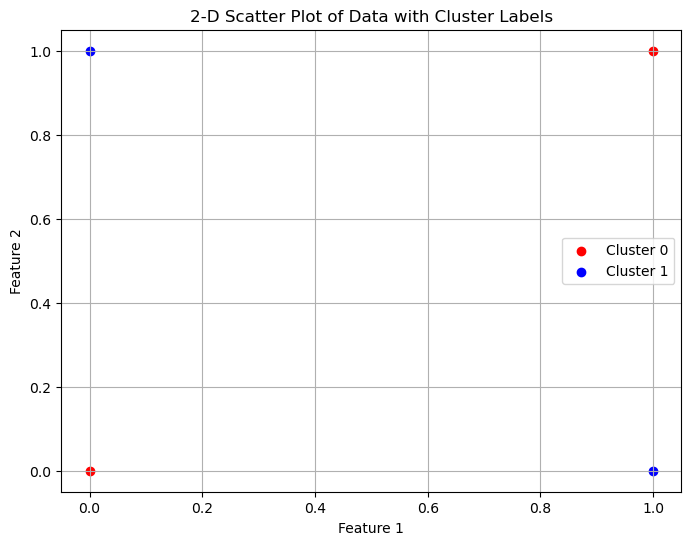

In [ ]:
import matplotlib.pyplot as plt
features = data[:, :2]
labels = data[:, 2]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='red', label='Cluster 0')
plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='blue', label='Cluster 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2-D Scatter Plot of Data with Cluster Labels')
plt.legend()
plt.grid(True)
plt.show()

# Q2.3

In [ ]:
import numpy as np

# Provided dataset
data = np.array([
    [0.1, -2, 0],
    [0, -1, 1],
    [0, 0, 0],
    [0, 1, 0],
    [0, 2, 0],
    [0, 3, 0],
    [0, 4, 0],
    [0, 5, 0],
    [0, 6, 1],
    [0, 7, 0],
    [0, 8, 1]
])

# Separate features and labels
X = data[:, :-1]
y = data[:, -1]

# Calculate entropy of the original dataset
def calculate_entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

entropy_original = calculate_entropy(y)

# Initialize lists to store results
splits = []
information_gains = []

# Calculate information gain ratio for each feature
for feature_index in range(X.shape[1]):
    feature_values = X[:, feature_index]

    # Sort and find unique feature values
    unique_feature_values = np.unique(feature_values)
    unique_feature_values.sort()

    # Calculate information gain ratio for each split
    for i in range(1, len(unique_feature_values) + 1):
        threshold = unique_feature_values[i - 1]
        print(threshold)
        mask_left = feature_values >= threshold
        mask_right = ~mask_left
        y_left = y[mask_left]
        y_right = y[mask_right]

        entropy_left = calculate_entropy(y_left)
        entropy_right = calculate_entropy(y_right)

        # Calculate information gain
        info_gain = entropy_original - (len(y_left) / len(y)) * entropy_left - (len(y_right) / len(y)) * entropy_right

        # Calculate split information
        split_info = -(len(y_left) / len(y)) * np.log2(len(y_left) / len(y) + 1e-10) - \
                     (len(y_right) / len(y)) * np.log2(len(y_right) / len(y) + 1e-10)

        # Calculate information gain ratio
        gain_ratio = info_gain / split_info if split_info != 0 else info_gain

        splits.append((feature_index, threshold))
        information_gains.append(gain_ratio)

# Print the results
print("Candidate splits and their information gain ratios:")
for i in range(len(splits)):
    feature_index, threshold = splits[i]
    print(f"Split at Feature {feature_index + 1}, Threshold {threshold:.2f} -> Information Gain Ratio: {information_gains[i]:.2f}")


0.0
0.1
-2.0
-1.0
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
Candidate splits and their information gain ratios:
Split at Feature 1, Threshold 0.00 -> Information Gain Ratio: -0.00
Split at Feature 1, Threshold 0.10 -> Information Gain Ratio: 0.10
Split at Feature 2, Threshold -2.00 -> Information Gain Ratio: -0.00
Split at Feature 2, Threshold -1.00 -> Information Gain Ratio: 0.10
Split at Feature 2, Threshold 0.00 -> Information Gain Ratio: 0.06
Split at Feature 2, Threshold 1.00 -> Information Gain Ratio: 0.01
Split at Feature 2, Threshold 2.00 -> Information Gain Ratio: 0.00
Split at Feature 2, Threshold 3.00 -> Information Gain Ratio: 0.02
Split at Feature 2, Threshold 4.00 -> Information Gain Ratio: 0.05
Split at Feature 2, Threshold 5.00 -> Information Gain Ratio: 0.11
Split at Feature 2, Threshold 6.00 -> Information Gain Ratio: 0.24
Split at Feature 2, Threshold 7.00 -> Information Gain Ratio: 0.06
Split at Feature 2, Threshold 8.00 -> Information Gain Ratio: 0.43


# Q2.4

In [14]:


# Provided dataset
data = np.array([
    [10, 1, 1],
    [10, 2, 1],
    [10, 3, 1],
    [1, 1, 0],
    [1, 3, 1]
])

# Separate features and labels
X = data[:, :-1]
y = data[:, -1]




# Fit the decision tree classifier
classifier = DecisionTreeClassifier()
classifier.fit(X, y)

# Print the trained decision tree
print("Trained Decision Tree:")
classifier.print_tree(feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])


visualize_decision_tree_graphviz(classifier, file_name='Q2.4_tree_graph')


Trained Decision Tree:
if Feature 1 >= 10.0000:
  Class: Class 1
else:
  if Feature 2 >= 3.0000:
    Class: Class 1
  else:
    Class: Class 0


# Q2.5

In [4]:
data = np.loadtxt('D1.txt')

X = data[:, :-1]
y = data[:, -1]
# Fit the decision tree classifier
classifier1 = DecisionTreeClassifier()
classifier1.fit(X, y)
print("Trained Decision Tree on D1:")
classifier1.print_tree(feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])
visualize_decision_tree_graphviz(classifier1, file_name='Q2.5_tree_graph1')


Trained Decision Tree on D1:
if Feature 2 >= 0.2018:
  Class: Class 1
else:
  Class: Class 0


In [4]:
data = np.loadtxt('D2.txt')

X = data[:, :-1]
y = data[:, -1]
# Fit the decision tree classifier
classifier2 = DecisionTreeClassifier()
classifier2.fit(X, y)
print("Trained Decision Tree on D2:")
classifier2.print_tree(feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])
visualize_decision_tree_graphviz(classifier2, file_name='Q2.5_tree_graph2')


Trained Decision Tree on D2:
if Feature 1 >= 0.5331:
  if Feature 2 >= 0.2280:
    if Feature 2 >= 0.4249:
      Class: Class 1
    else:
      if Feature 1 >= 0.7081:
        Class: Class 1
      else:
        if Feature 2 >= 0.3262:
          if Feature 1 >= 0.5955:
            if Feature 1 >= 0.6460:
              Class: Class 1
            else:
              if Feature 2 >= 0.4035:
                Class: Class 1
              else:
                Class: Class 0
          else:
            Class: Class 0
        else:
          Class: Class 0
  else:
    if Feature 1 >= 0.8872:
      if Feature 2 >= 0.0377:
        if Feature 2 >= 0.0829:
          Class: Class 1
        else:
          if Feature 1 >= 0.9608:
            Class: Class 1
          else:
            Class: Class 0
      else:
        Class: Class 0
    else:
      if Feature 1 >= 0.8503:
        if Feature 2 >= 0.1691:
          Class: Class 1
        else:
          Class: Class 0
      else:
        Class: Class 0

# Q2.6

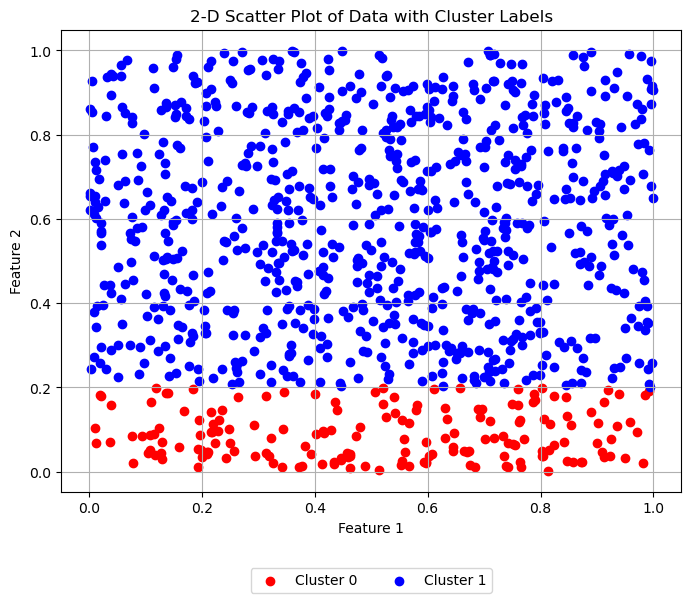

In [6]:
import matplotlib.pyplot as plt


data = np.loadtxt('/Users/zexuansun/Downloads/D1.txt')


features = data[:, :2]
labels = data[:, 2]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='red', label='Cluster 0')
plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='blue', label='Cluster 1')


#plt.axhline(y=classifier1.root.threshold, color='green', linestyle='-', label='DT decision boundary',lw = 3)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2-D Scatter Plot of Data with Cluster Labels')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.grid(True)
plt.show()

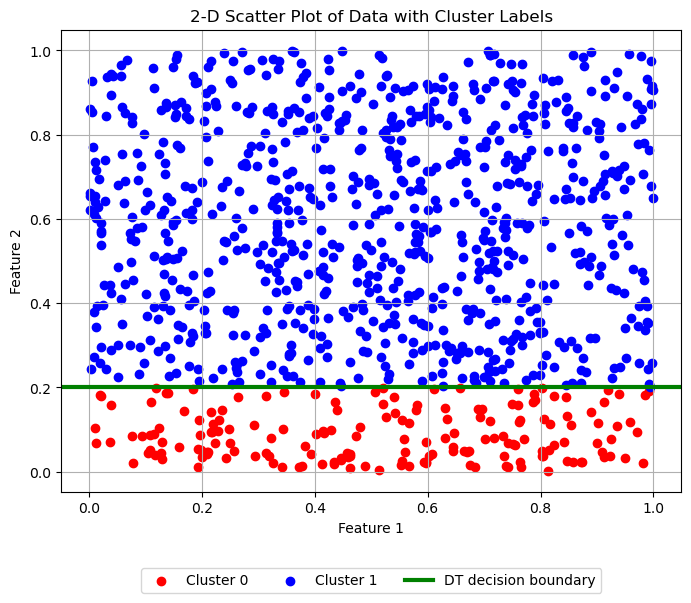

In [7]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='red', label='Cluster 0')
plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='blue', label='Cluster 1')


plt.axhline(y=classifier1.root.threshold, color='green', linestyle='-', label='DT decision boundary',lw = 3)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2-D Scatter Plot of Data with Cluster Labels')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.grid(True)
plt.show()

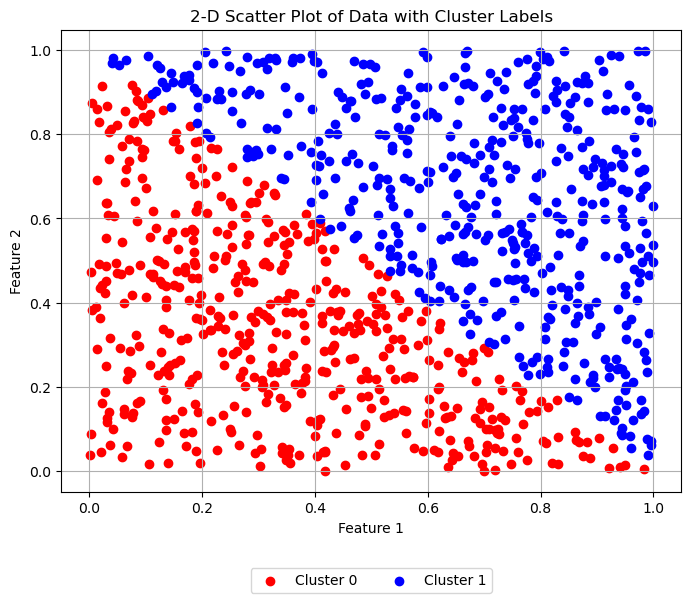

In [9]:
data = np.loadtxt('/Users/zexuansun/Downloads/D2.txt')

features = data[:, :2]
labels = data[:, 2]
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='red', label='Cluster 0')
plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='blue', label='Cluster 1')


#plt.axhline(y=classifier1.root.threshold, color='green', linestyle='-', label='DT decision boundary',lw = 3)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2-D Scatter Plot of Data with Cluster Labels')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.grid(True)
plt.show()

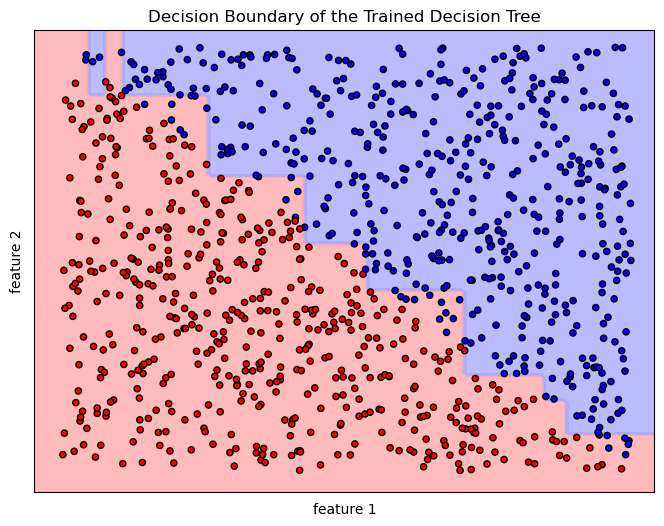

In [ ]:
import matplotlib.pyplot as plt


data = np.loadtxt('/Users/zexuansun/Downloads/D2.txt')


X = data[:, :2]
y = data[:, 2]


classifier2.plot_decision_boundary(X,y)

# Create a scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(features[labels == 0, 0], features[labels == 0, 1], c='red', label='Cluster 0')
# plt.scatter(features[labels == 1, 0], features[labels == 1, 1], c='blue', label='Cluster 1')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('2-D Scatter Plot of Data with Cluster Labels')
# plt.legend()
# plt.grid(True)
# plt.show()

# Q2.7

In [145]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(0)

data = np.loadtxt('/Users/zexuansun/Downloads/Dbig.txt')


# Generate a synthetic dataset with 10,000 labeled items
num_items = 10000
features = data[:,:2]  # Example: 2 features
labels =data[:,2]  # Example: Binary labels (0 or 1)

# Create a random permutation of indices
indices = np.random.permutation(num_items)

# Split the data into a training set (8192 items) and a test set (the rest)
split_ratio = 8192
train_indices = indices[:split_ratio]
test_indices = indices[split_ratio:]

# Split the features and labels
X_train = features[train_indices]
y_train = labels[train_indices]
X_test = features[test_indices]
y_test = labels[test_indices]

# Optionally, you can save the datasets to text files if needed
# np.savetxt("X_train.txt", X_train)
# np.savetxt("y_train.txt", y_train)
# np.savetxt("X_test.txt", X_test)
# np.savetxt("y_test.txt", y_test)



# Define the sizes for the nested training sets
training_set_sizes = [32, 128, 512, 2048, 8192]

# Initialize a list to store the nested training sets
nested_training_sets = []

# Generate the nested training sets
for size in training_set_sizes:
    nested_training_indices = indices[:size]
    nested_training_features = features[nested_training_indices]
    nested_training_labels = labels[nested_training_indices]
    nested_training_sets.append((nested_training_features, nested_training_labels))

# Print the sizes of the nested training sets
for i, (X_train, y_train) in enumerate(nested_training_sets):
    print(f"Size of D{training_set_sizes[i]}: {len(X_train)} items")







Size of D32: 32 items
Size of D128: 128 items
Size of D512: 512 items
Size of D2048: 2048 items
Size of D8192: 8192 items


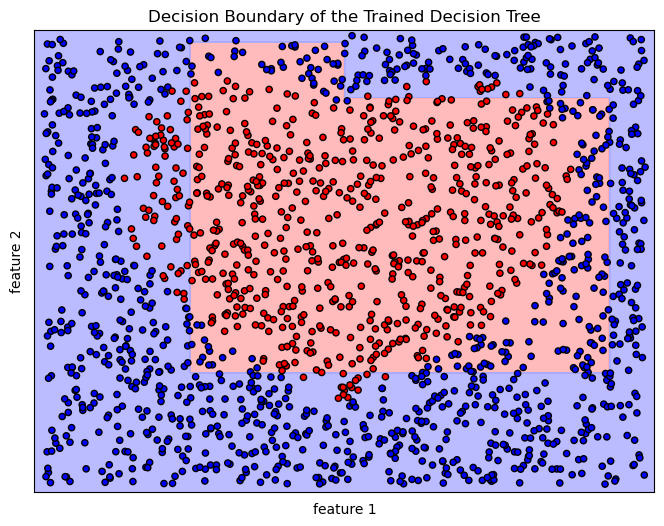

Test error for D32: 0.1687
Num of nodes for D32: 13


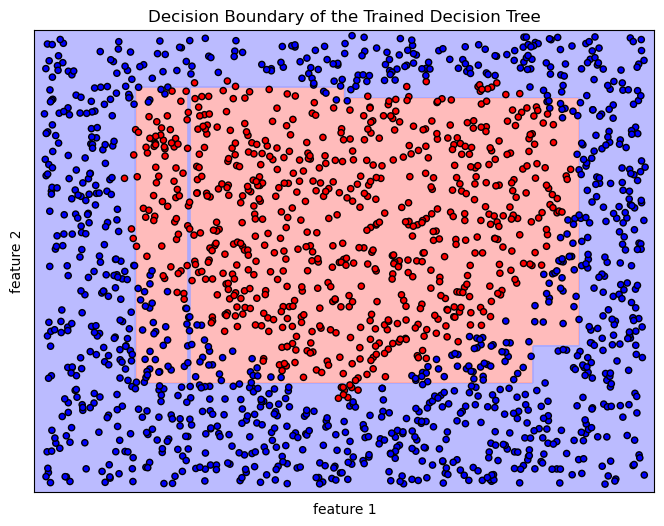

Test error for D128: 0.1056
Num of nodes for D128: 21


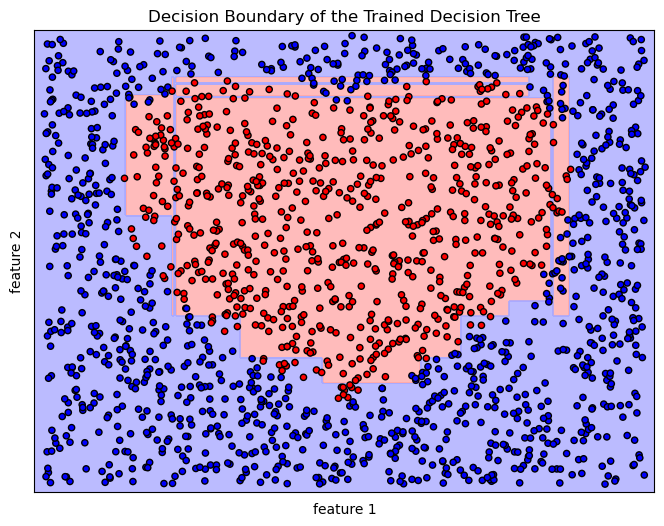

Test error for D512: 0.0570
Num of nodes for D512: 57


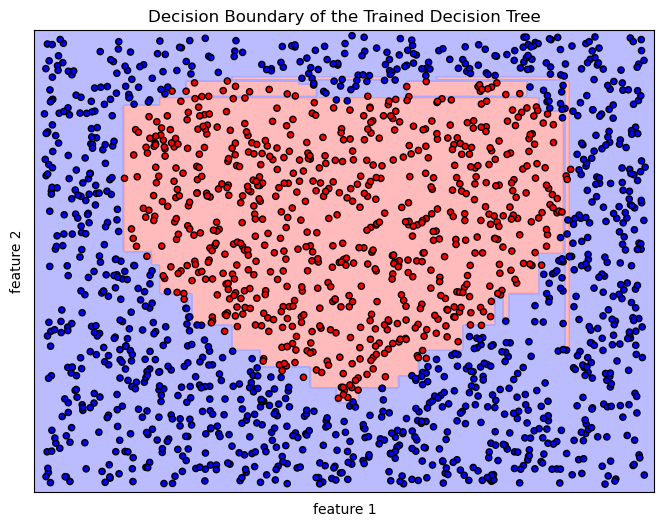

Test error for D2048: 0.0221
Num of nodes for D2048: 131


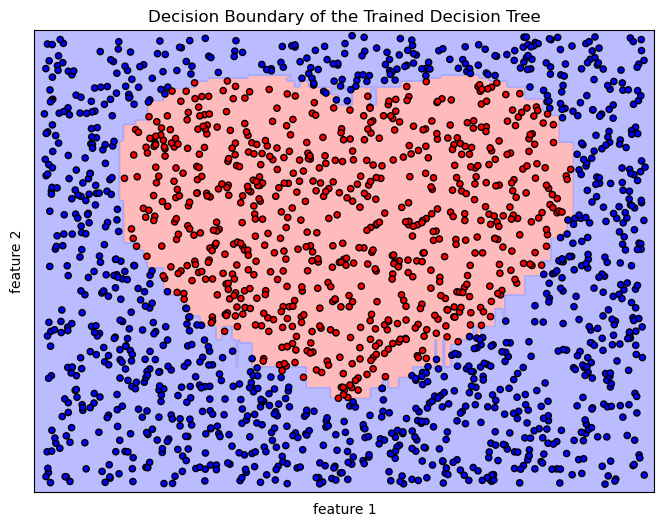

Test error for D8192: 0.0127
Num of nodes for D8192: 291


In [146]:

from sklearn.metrics import accuracy_score

# Define a function to train a decision tree and measure test set error
def train_and_measure_error(X_train, y_train, X_test, y_test):
    # Create and train a decision tree classifier
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)
    classifier.plot_decision_boundary(X_test,y_test)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)
    root_node = classifier.root
    count_node = count_nodes(root_node)
    # Calculate the test set error (errn)
    test_error = 1.0 - accuracy_score(y_test, y_pred)

    return test_error,count_node

# Initialize a list to store the test errors for each Dn
test_errors = []
num_nodes = []
# Train decision trees and measure test errors for each Dn
for i, (X_train, y_train) in enumerate(nested_training_sets):
    test_error,count_node = train_and_measure_error(X_train, y_train, X_test,y_test)
    test_errors.append(test_error)
    num_nodes.append(count_node)
    print(f"Test error for D{training_set_sizes[i]}: {test_error:.4f}")
    print(f"Num of nodes for D{training_set_sizes[i]}: {count_node}")


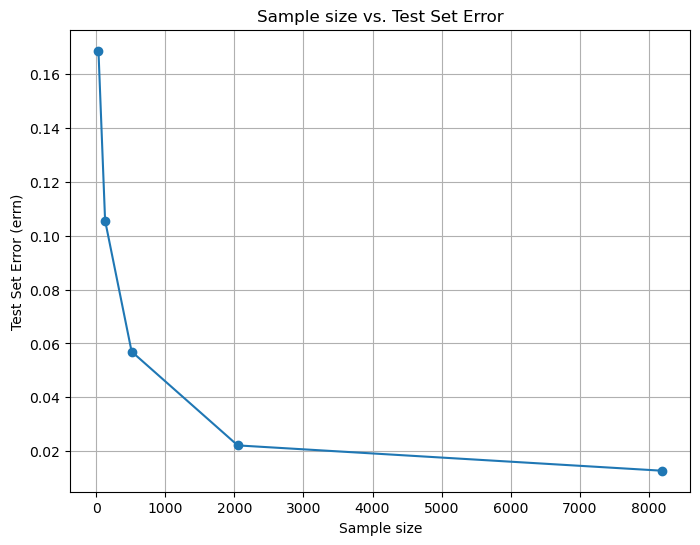

In [147]:
plt.figure(figsize=(8, 6))
plt.plot(training_set_sizes , test_errors, marker='o', linestyle='-')
plt.xlabel('Sample size')
plt.ylabel('Test Set Error (errn)')
plt.title('Sample size vs. Test Set Error')
plt.grid(True)
plt.show()

# Q3

D32, Number of Nodes = 11, Test Error (errn) = 0.1338
D128, Number of Nodes = 21, Test Error (errn) = 0.0874
D512, Number of Nodes = 59, Test Error (errn) = 0.0470
D2048, Number of Nodes = 121, Test Error (errn) = 0.0232
D8192, Number of Nodes = 249, Test Error (errn) = 0.0100


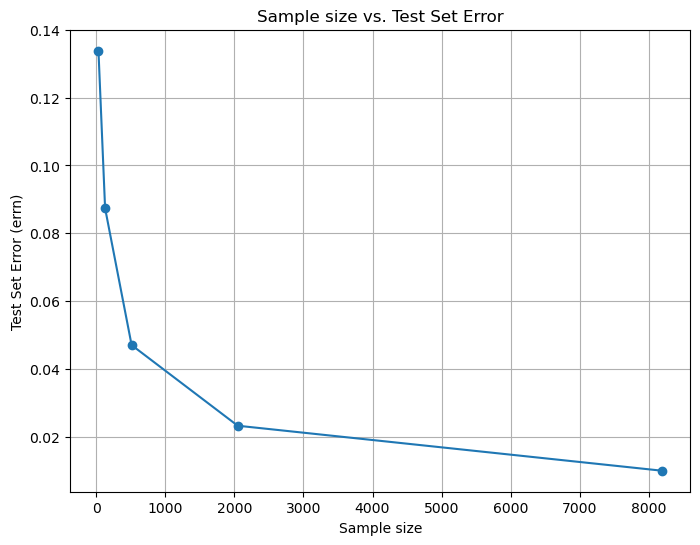

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize lists to store results
n_values = training_set_sizes
node_counts = []
test_errors = []




for i, (X_train, y_train) in enumerate(nested_training_sets):

    # Create and train a decision tree classifier
    classifier = DecisionTreeClassifier()
    classifier.fit(X_train, y_train)

    # Measure the number of nodes in the tree
    num_nodes = classifier.tree_.node_count

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate the test set error (errn)
    test_error = 1.0 - accuracy_score(y_test, y_pred)

    # Append results to lists
    node_counts.append(num_nodes)
    test_errors.append(test_error)

# Print n, number of nodes, and errn
for n, nodes, error in zip(n_values, node_counts, test_errors):
    print(f"D{n}, Number of Nodes = {nodes}, Test Error (errn) = {error:.4f}")

# Plot n vs. errn
plt.figure(figsize=(8, 6))
plt.plot( training_set_sizes , test_errors, marker='o', linestyle='-')
plt.xlabel('Sample size')
plt.ylabel('Test Set Error (errn)')
plt.title('Sample size vs. Test Set Error')
plt.grid(True)
plt.show()


# Q4

Log Train Error: 322.4283098030152
Log Test Error: 322.20716744707994


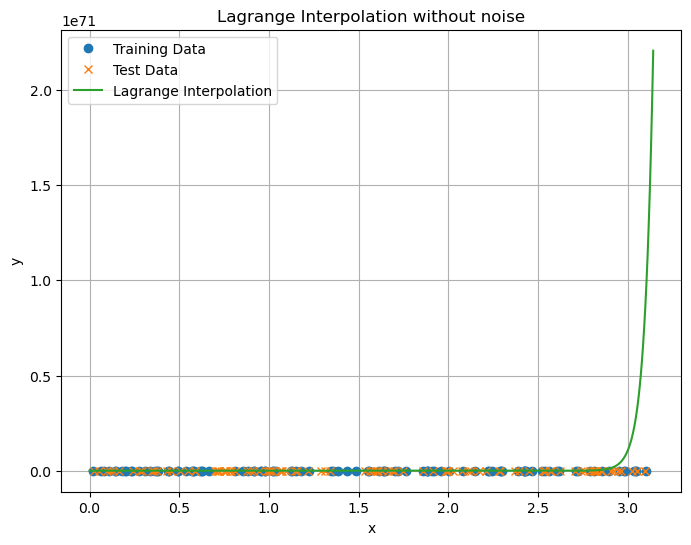

In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange

# Function to generate a training set with or without Gaussian noise
def generate_dataset(n, a, b):
    #noise = np.random.normal(0, noise_std, n)
    x = np.random.uniform(a, b, n) 
    y = np.sin(x) 
    return x, y

# Function to compute Lagrange interpolation and errors
def interpolate_and_compute_errors(x_train, y_train, x_test, y_test):
    # Interpolate using Lagrange polynomial
    lagrange_poly = lagrange(x_train, y_train)
    
    # Compute interpolated values for both training and test data
    y_train_pred = lagrange_poly(x_train)
    y_test_pred = lagrange_poly(x_test)
    
    # Calculate errors (mean squared error)
    train_error = np.mean((y_train - y_train_pred) ** 2)
    test_error = np.mean((y_test - y_test_pred) ** 2)
    
    return train_error, test_error, lagrange_poly

# Define experiment parameters
np.random.seed(42)  # For reproducibility
n = 100
a, b = 0,  np.pi  # Interval [0, 2π]

# Generate training and test sets
x_train, y_train = generate_dataset(n, a, b)
x_test, y_test = generate_dataset(n, a, b)

# Perform interpolation and compute errors
train_error, test_error, lagrange_poly = interpolate_and_compute_errors(x_train, y_train, x_test, y_test)

# Print errors
print("Log Train Error:", np.log(train_error))
print("Log Test Error:", np.log(test_error))

# Plot the results on a log scale for the y-axis
plt.figure(figsize=(8, 6))
plt.plot(x_train, y_train, 'o', label="Training Data")
plt.plot(x_test, y_test, 'x', label="Test Data")
x_plot = np.linspace(a,b, 1000)
plt.plot(x_plot, lagrange_poly(x_plot), label="Lagrange Interpolation")
#plt.yscale('log')  # Use log scale for y-axis
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Lagrange Interpolation without noise")
plt.grid(True)
plt.show()


Log Train Error: 265.9708220663123
Log Test Error: 59.92425551704578


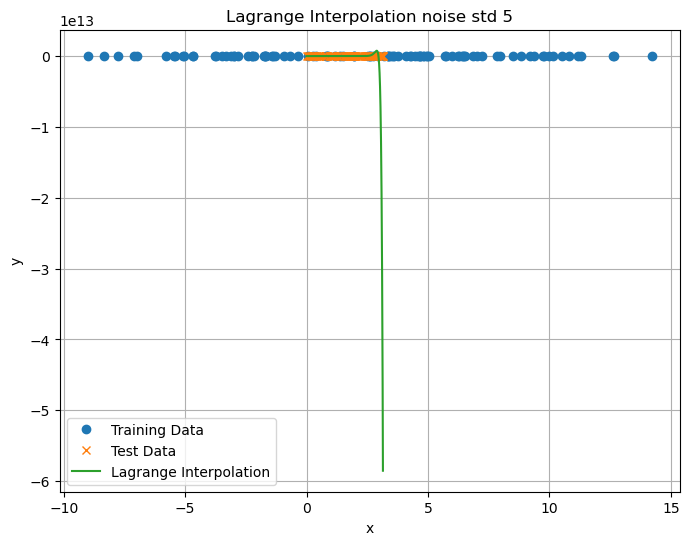

In [131]:
noise_std = 5
noise = np.random.normal(0, noise_std, n)
x_train, y_train = generate_dataset(n, a, b)
x_test, y_test = generate_dataset(n, a, b)
x_train_tmp = x_train + noise
y_train_tmp = np.sin(x_train_tmp)

#x_test, y_test = generate_dataset(n, a, b, noise_std=10)

# Perform interpolation and compute errors
train_error, test_error, lagrange_poly = interpolate_and_compute_errors(x_train_tmp, y_train_tmp, x_test, y_test)

# Print errors
print("Log Train Error:", np.log(train_error))
print("Log Test Error:", np.log(test_error))

# Plot the results on a log scale for the y-axis
plt.figure(figsize=(8, 6))
plt.plot(x_train_tmp, y_train_tmp, 'o', label="Training Data")
plt.plot(x_test, y_test, 'x', label="Test Data")
#x_plot = np.linspace(a, b, 1000)
x_plot = np.linspace(min(x_train_tmp), max(x_train_tmp), 1000)
x_plot = np.linspace(a, b, 1000)
title = "Lagrange Interpolation Noise std " + str(noise_std)
plt.plot(x_plot, lagrange_poly(x_plot), label = 'Lagrange Interpolation')
#plt.yscale('log')  # Use log scale for y-axis
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(title)
plt.grid(True)
plt.show()

Log Train Error: 258.01128430508766
Log Test Error: -0.12513691890809275


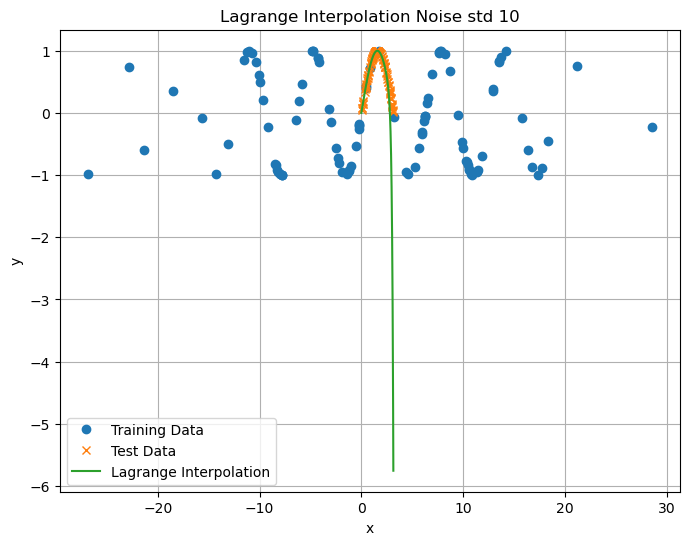

In [138]:
noise_std = 10
#np.random.seed(189)
noise = np.random.normal(0, noise_std, n)
x_train, y_train = generate_dataset(n, a, b)
x_test, y_test = generate_dataset(n, a, b)
x_train_tmp = x_train + noise
y_train_tmp = np.sin(x_train_tmp)

#x_test, y_test = generate_dataset(n, a, b, noise_std=10)

# Perform interpolation and compute errors
train_error, test_error, lagrange_poly = interpolate_and_compute_errors(x_train_tmp, y_train_tmp, x_test, y_test)

# Print errors
print("Log Train Error:", np.log(train_error))
print("Log Test Error:", np.log(test_error))

# Plot the results on a log scale for the y-axis
plt.figure(figsize=(8, 6))
plt.plot(x_train_tmp, y_train_tmp, 'o', label="Training Data")
plt.plot(x_test, y_test, 'x', label="Test Data")
#x_plot = np.linspace(a, b, 1000)
x_plot = np.linspace(min(x_train_tmp), max(x_train_tmp), 1000)
x_plot = np.linspace(a, b, 1000)
title = "Lagrange Interpolation Noise std " + str(noise_std)
plt.plot(x_plot, lagrange_poly(x_plot), label = 'Lagrange Interpolation')
#plt.yscale('log')  # Use log scale for y-axis
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(title)
plt.grid(True)
plt.show()

Log Train Error: 237.6847071922394
Log Test Error: -27.885813659978396


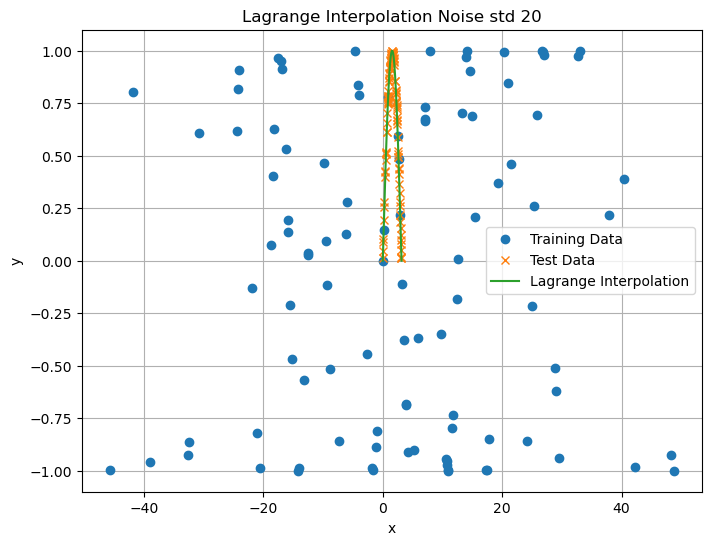

In [140]:
noise_std = 20
noise = np.random.normal(0, noise_std, n)
x_train, y_train = generate_dataset(n, a, b)
x_test, y_test = generate_dataset(n, a, b)
x_train_tmp = x_train + noise
y_train_tmp = np.sin(x_train_tmp)

#x_test, y_test = generate_dataset(n, a, b, noise_std=10)

# Perform interpolation and compute errors
train_error, test_error, lagrange_poly = interpolate_and_compute_errors(x_train_tmp, y_train_tmp, x_test, y_test)

# Print errors
print("Log Train Error:", np.log(train_error))
print("Log Test Error:", np.log(test_error))

# Plot the results on a log scale for the y-axis
plt.figure(figsize=(8, 6))
plt.plot(x_train_tmp, y_train_tmp, 'o', label="Training Data")
plt.plot(x_test, y_test, 'x', label="Test Data")
#x_plot = np.linspace(a, b, 1000)
x_plot = np.linspace(min(x_train_tmp), max(x_train_tmp), 1000)
x_plot = np.linspace(a, b, 1000)
title = "Lagrange Interpolation Noise std " + str(noise_std)
plt.plot(x_plot, lagrange_poly(x_plot), label = 'Lagrange Interpolation')
#plt.yscale('log')  # Use log scale for y-axis
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(title)
plt.grid(True)
plt.show()

In [126]:

noise_stds = np.arange(0,21)
train_errs = []
test_errs= []


for noise_std in noise_stds:

    noise = np.random.normal(0, noise_std, n)
    x_train, y_train = generate_dataset(n, a, b)
    x_test, y_test = generate_dataset(n, a, b)
    x_train_tmp = x_train + noise
    y_train_tmp = np.sin(x_train_tmp)

    #x_test, y_test = generate_dataset(n, a, b, noise_std=10)

    # Perform interpolation and compute errors
    train_error, test_error, lagrange_poly = interpolate_and_compute_errors(x_train_tmp, y_train_tmp, x_test, y_test)
    train_errs.append(train_error)
    test_errs.append(test_error)
# train_errs = np.log(train_errs)
# test_errs= np.log(test_errs)


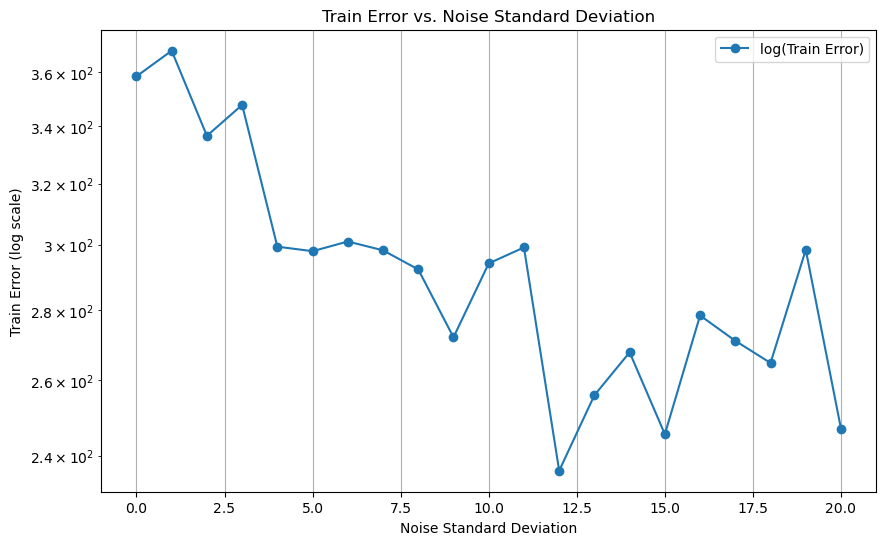

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(noise_stds, np.log(train_errs), label='log(Train Error)', marker='o')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Train Error (log scale)')
plt.title('Train Error vs. Noise Standard Deviation')
plt.yscale('log')  # Set the y-axis to log scale
plt.grid(True)
plt.legend()
plt.show()


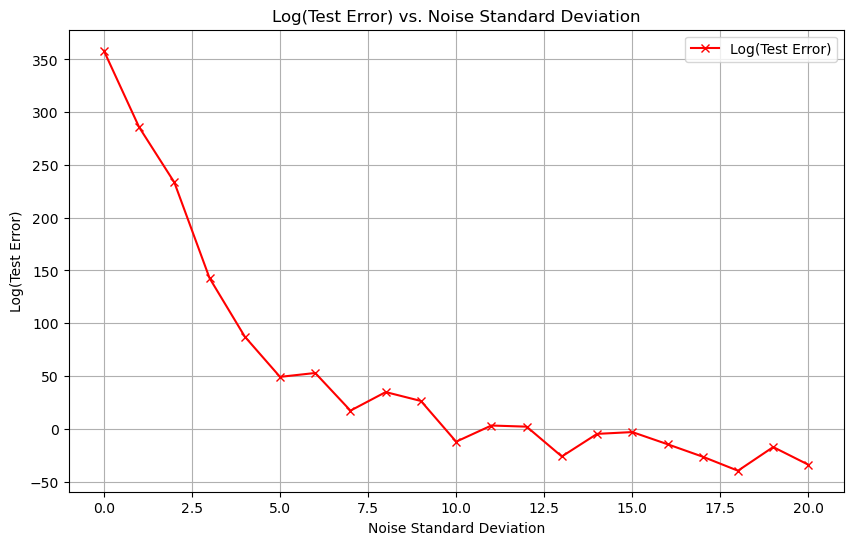

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(noise_stds, np.log(test_errs), label='Log(Test Error)', marker='x',color = 'red')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Log(Test Error)')
plt.title('Log(Test Error) vs. Noise Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()